# C1 - Introduction to Human and Computer Vision
## Week 4

In [1]:
import os
import re
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week4')
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = '../data'

In [2]:
# Read pickle file to see detailed info of the images augmentation
with open(f'{DATA_DIRECTORY}/qsd1_w4/augmentations.pkl', 'rb') as f:
    augmentations_info = pickle.load(f)

In [3]:
# Read pickle file with correspondences
with open(f'{DATA_DIRECTORY}/qsd1_w4/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

### a) Remove background, detect noise (and filter it)

In [4]:
from src.background_removal import background_removal
from src.noise_removal import denoise_image
from tqdm import tqdm

# Image names
QSD1_w4_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd1_w4/') if f.endswith('.jpg')]
QSD1_w4_names.sort()

# Initialize datasets
BBDD = []
QSD1_w4 = []
QSD1_w4_filtered = []
QSD1_w4_nonAugmented = []

# Load datasets (+ filter)
for image_name in tqdm(QSD1_w4_names):
    # Read QSD1_w4
    image_qsd1 = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/{image_name}')
    QSD1_w4.append(image_qsd1)

    # Read non-augmented image
    image_nonAugmented = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/non_augmented/{image_name}')
    image_nonAug_bckg_remov = background_removal(image_nonAugmented)  # Remove background in non-augmented image
   
    QSD1_w4_nonAugmented.append(image_nonAug_bckg_remov)

    # Filter image from QSD1_w4
    filtered_image = background_removal(denoise_image(image_qsd1))  # Detect noise (and clean it) + Remove background
    QSD1_w4_filtered.append(filtered_image)


# Read BBDD
BBDD_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/BBDD/') if f.endswith('.jpg')]
BBDD_names.sort()

for image_name in tqdm(BBDD_names):
    image_bbdd = cv2.imread(f'{DATA_DIRECTORY}/BBDD/{image_name}')
    BBDD.append(image_bbdd)

100%|██████████| 287/287 [00:06<00:00, 47.79it/s]


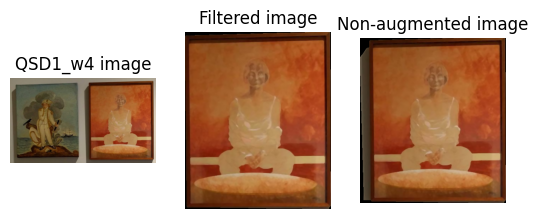

In [39]:
# Plot some examples
img_number = 2


fig, axes = plt.subplots(1, 3)  # 1 fila, 3 columnas

# QSD1_w4 image
image = QSD1_w4[img_number]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[0].imshow(image)
axes[0].set_title('QSD1_w4 image')
axes[0].axis('Off')

# Filtered image (background removal + denoise)
image = QSD1_w4_filtered[img_number][0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[1].imshow(image)
axes[1].set_title('Filtered image')
axes[1].axis('Off')

# Non-augmented image
image = QSD1_w4_nonAugmented[img_number][0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[2].imshow(image)
axes[2].set_title('Non-augmented image')
axes[2].axis('Off')

plt.show()
plt.close()

### b) Detect keypoints and compute descriptors

In [6]:
'''
flags = {
  DEFAULT = 0,
  DRAW_OVER_OUTIMG = 1,
  NOT_DRAW_SINGLE_POINTS = 2,
  DRAW_RICH_KEYPOINTS = 4
}
'''
def draw_keypoints(image, kp, flags=0):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img2 = cv2.drawKeypoints(gray_image, kp, None,(255,0,0),flags=flags)
    plt.imshow(img2) 

#### SIFT

In [7]:
def sift_descriptor(image, params={}):
    '''
    Compute SIFT descriptors for a given image
    :param image: image to compute the descriptors
    :param params: parameters for the SIFT algorithm
    :return: keypoints and descriptors

    default params = {
        'nfeatures': 0,
        'nOctaveLayers': 3,
        'contrastThreshold': 0.04,
        'edgeThreshold': 10,
        'sigma': 1.6
    }
    '''
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(**params)
    kp, des = sift.detectAndCompute(img_gray, None)

    return (kp, des)

In [8]:
sift_query = []
for picture in tqdm(QSD1_w4_filtered):
    res = []
    for painting in picture:
        kp, des = sift_descriptor(painting)
        res.append({'kp': kp, 'des': des})
    sift_query.append(res)


sift_bd = []
for painting in tqdm(BBDD):
    kp, des = sift_descriptor(painting)
    sift_bd.append({'kp': kp, 'des': des})

100%|██████████| 287/287 [03:31<00:00,  1.35it/s]


In [19]:
des1 = sift_query[3][0]['des']
des2 = sift_bd[32]['des']

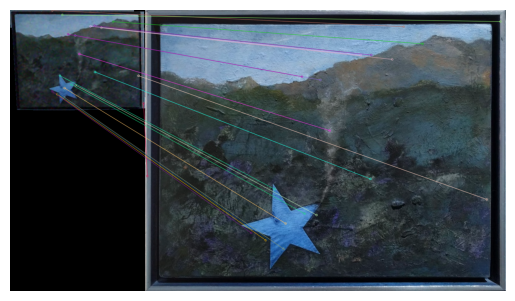

(<matplotlib.image.AxesImage at 0x7ec7f4fafd40>,
 (np.float64(-0.5), np.float64(1591.5), np.float64(901.5), np.float64(-0.5)),
 None)

In [20]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(
    QSD1_w4_filtered[3][0], sift_query[3][0]['kp'],
    BBDD[32], sift_bd[32]['kp'],
    matches[:20], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.imshow(img3), plt.axis('off'), plt.show()

In [38]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

res = []
for i in range(2, 3):
    picture_res = []
    for j in range(0, len(sift_query[i])):
        distances = []
        for k in tqdm(range(0, len(sift_bd))):
            if sift_bd[k]['des'] is not None:
                matches = bf.match(sift_query[i][j]['des'], sift_bd[k]['des'])
                matches = sorted(matches, key = lambda x:x.distance)
                # Take top 20 matches
                distance = np.mean([match.distance for match in matches[:20]])
                distances.append(distance)
            else:
                distances.append(10000)

        # Take top 10 matches
        most_similar = np.argsort(distances)[:10]
        picture_res.append(most_similar)
    
    res.append(picture_res)


100%|██████████| 287/287 [00:07<00:00, 39.21it/s]


251


100%|██████████| 287/287 [00:19<00:00, 14.85it/s]

48


In [31]:
ground_truth[2]

[48, 251]

In [40]:
res

[[array([251, 116, 273, 260, 232,  16, 215,  70, 248,  54]),
  array([ 48, 248, 116, 147, 273,  16, 120,  60, 259, 218])]]

#### HOG

In [54]:
from skimage.feature import hog
from skimage import exposure

image = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/00000.jpg')
image1 = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/00001.jpg')

# Convertir a escala de grises
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

image = cv2.resize(image, (256, 256))
image1 = cv2.resize(image1, (256, 256))


In [55]:
fd1, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
fd2, hog_image1 = hog(image1, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

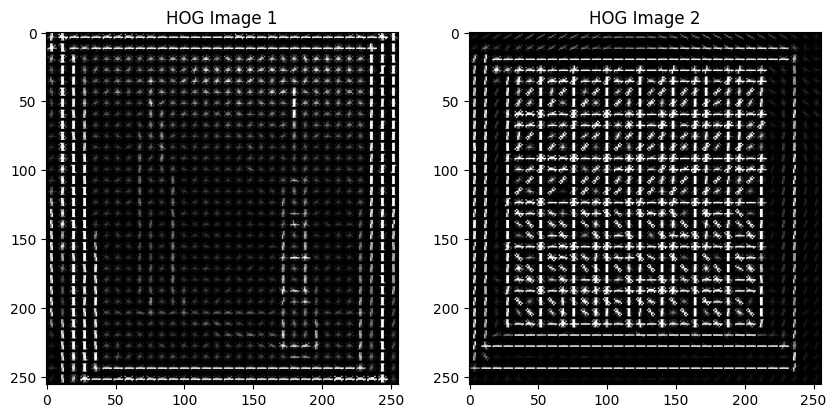

In [56]:
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
hog_image1 = exposure.rescale_intensity(hog_image1, in_range=(0, 10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(hog_image, cmap='gray')
ax1.set_title('HOG Image 1')
ax2.imshow(hog_image1, cmap='gray')
ax2.set_title('HOG Image 2')
plt.show()

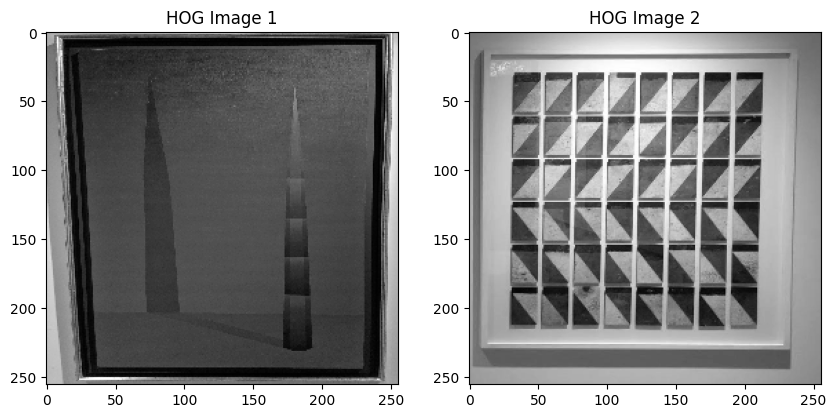

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image, cmap='gray')
ax1.set_title('HOG Image 1')
ax2.imshow(image1, cmap='gray')
ax2.set_title('HOG Image 2')
plt.show()

In [58]:
from scipy.spatial.distance import euclidean

# Calcular la distancia entre los descriptores HOG
distance = euclidean(fd1, fd2)
print(f'Distancia entre las imágenes: {distance}')

Distancia entre las imágenes: 27.018527261555985


#### DAISY

In [ ]:
from skimage.feature import daisy

def daisy_descriptor(image, step=250, radius=50, rings=3, histograms=6, orientations=8):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculamos los descriptores DAISY sin visualización
    descriptors, dsc_image = daisy(
        gray_image,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=True
    )
    
    return descriptors, dsc_image


In [30]:
def daisy_descriptor(image, step=158, radius=50, rings=3, histograms=6, orientations=8):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Usamos un detector de keypoints (aquí FAST, pero puedes usar otros)
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(gray_image, None)
    
    # Calculamos los descriptores DAISY en los puntos clave detectados
    descriptors = daisy(
        gray_image,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=False
    )
    
    # Alineamos los descriptores con los keypoints (si es necesario)
    keypoints_daisy = []
    keypoint_descriptors = []
    
    for kp in keypoints:
        # Para cada keypoint, calculamos su posición (en coordenadas de píxeles)
        y, x = kp.pt
        x, y = int(x), int(y)
        
        # Aquí usamos una verificación simple, que si el keypoint está dentro de la imagen
        if x < descriptors.shape[1] and y < descriptors.shape[0]:
            keypoints_daisy.append(kp)
            keypoint_descriptors.append(descriptors[y, x, :])  # Tomamos el descriptor en esa ubicación
    
    # Convertimos las listas a arrays de numpy para facilitar el uso
    keypoints_daisy = np.array(keypoints_daisy)
    keypoint_descriptors = np.array(keypoint_descriptors)
    
    return keypoints_daisy, keypoint_descriptors

In [31]:
daisy_query = []
for picture in tqdm(QSD1_w4_filtered[:4]):
    for painting in picture:
        kp, des = daisy_descriptor(painting)
        daisy_query.append({'kp': kp, 'des': des})


daisy_bd = []
for picture in tqdm(QSD1_w4_nonAugmented[:4]):
    for painting in picture:
        kp, des = daisy_descriptor(painting)
        daisy_bd.append({'kp': kp, 'des': des})

 25%|██▌       | 1/4 [00:32<01:36, 32.33s/it]


ValueError: negative dimensions are not allowed

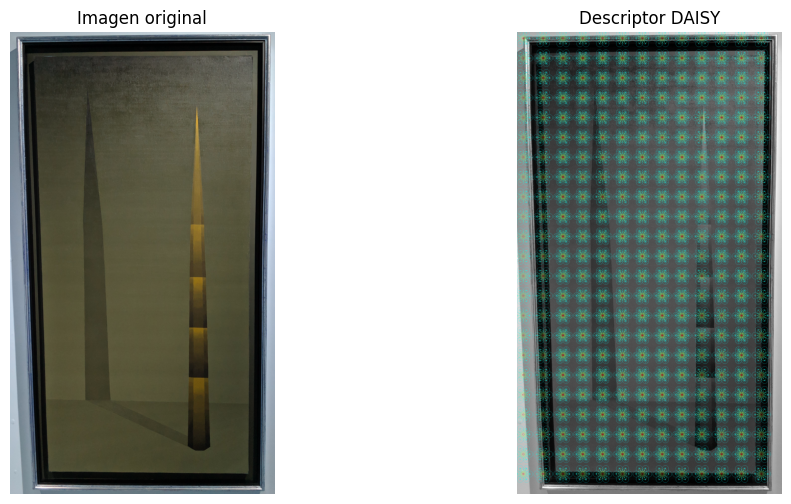

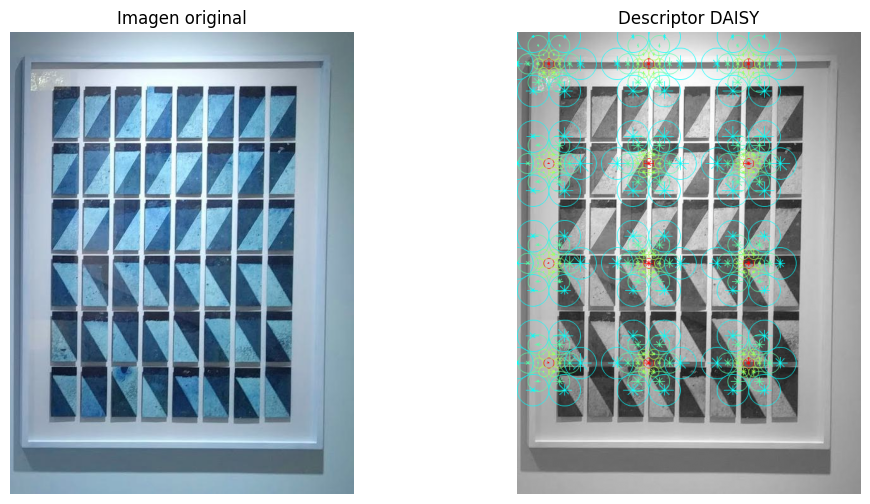

In [13]:
# Mostrar la imagen original y la visualización del descriptor DAISY
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dsc_image, cmap='gray')
plt.title('Descriptor DAISY')
plt.axis('off')

plt.show()

# 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dsc_image1, cmap='gray')
plt.title('Descriptor DAISY')
plt.axis('off')

plt.show()

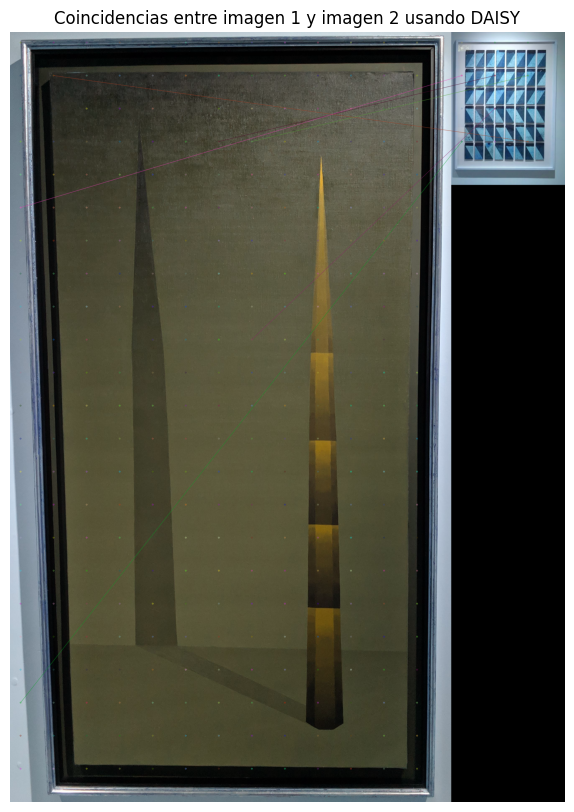

In [20]:
# Convertir descriptores a tipo float32 para el matcher de OpenCV
descriptors = des_daisy.astype(np.float32).reshape(-1, 152)
descriptors1 = des_daisy1.astype(np.float32).reshape(-1, 152)

# Crear el matcher Brute-Force con la métrica de distancia Euclidiana
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Encontrar las mejores coincidencias
matches = bf.match(descriptors, descriptors1)

# Ordenar las coincidencias por distancia (las más cercanas son las mejores)
matches = sorted(matches, key=lambda x: x.distance)

# Para dibujar los keypoints necesitamos crear un arreglo de KeyPoint
# Generar keypoints para la primera y segunda imagen a partir de la malla DAISY
keypoints = []
keypoints1 = []

step = 158  # El valor del 'step' usado en DAISY
radius = 50  # El radio del descriptor

# Generar keypoints para la imagen original
for i in range(des_daisy.shape[0]):
    for j in range(des_daisy.shape[1]):
        keypoints.append(cv2.KeyPoint(j * step + radius, i * step + radius, 1))

# Generar keypoints para la segunda imagen
for i in range(des_daisy1.shape[0]):
    for j in range(des_daisy1.shape[1]):
        keypoints1.append(cv2.KeyPoint(j * step + radius, i * step + radius, 1))

# Dibujar los matches entre las imágenes
img_matches = cv2.drawMatches(
    image, keypoints,  # Imagen original y sus keypoints
    image1, keypoints1,  # Imagen de referencia y sus keypoints
    matches[:30], None
)

# Mostrar el resultado con matplotlib
plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.title('Coincidencias entre imagen 1 y imagen 2 usando DAISY')
plt.axis('off')  # Desactivar los ejes para que sea más limpio
plt.show()



In [8]:
surf_query = []
for picture in tqdm(QSD1_w4_filtered):
    for painting in picture:
        kp, des = surf_descriptor(painting)
        surf_query.append({'kp': kp, 'des': des})


surf_bd = []
for picture in tqdm(QSD1_w4_nonAugmented):
    for painting in picture:
        kp, des = surf_descriptor(painting)
        surf_bd.append({'kp': kp, 'des': des})

  0%|          | 0/30 [00:00<?, ?it/s]


AttributeError: module 'cv2' has no attribute 'SURF_create'

#### ORB

In [ ]:
def orb_descriptor(image, params={}):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(**params)
    kp, des = orb.detectAndCompute(img_gray, None)

    return (kp, des)

# Task 2

### a) Find tentative matches based on similarity of local appearance and verify matches 

### b) Implement a system to discard queries not in the data set (unknowns)

# Task 3

### a) Evaluate system based on keypoint descriptors on QSD1-W4

### b) Compare your best query system from previous week on QSD1-W4

# Task 4

### a) Create pkl file